In [1]:
import os
import sys
import shutil
import glob
import importlib
#from pathlib import Path
import random

import numpy as np
import librosa
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.figure import figaspect
from sklearn.model_selection import train_test_split
import librosa.display
import IPython

repos_dir = r'/home/akikun/repos'
sys.path.append(repos_dir)
from sak import display as dp
from sak import signal_processing as sp
from sak import nele

# repos_imgan_dir = os.path.join(repos_dir, 'Intelligibility-MetricGAN')
# sys.path.append(repos_imgan_dir)
# import default_settings as default
# #import audio_util as au

In [6]:
# corpus_dir = r'/home/common/db/audio_corpora/nele'

# corpus_clean_dir = os.path.join(corpus_dir, 'hikari_tts')
# corpus_ssdrc_dir = os.path.join(corpus_dir, 'hikari_tts', 'wavs_ssdrc') 
# corpus_noise_dir = os.path.join(corpus_dir, 'train_noise', 'JR')

# data_dir = os.path.join(corpus_dir, 'imgan', 'per_snr')

# main_dir = r'/home/akikun/experiments/spotify'
# wav_dir_ = os.path.join(main_dir, 'wavs')
# wav_dir  = os.path.join(main_dir, 'wavs_normalized')

# clean wav path.
wav_clean_raw_dir = r'/home/common/db/audio_corpora/nele/jr_demo/clean_raw'
# target noise path.
wav_noise0_path = r'/home/common/db/audio_corpora/nele/train_noise/JR/wavs_normalized/train_noise7.wav'

wav_clean_dir = os.path.join(output_dir, 'clean')
wav_noise_dir = os.path.join(output_dir, 'noise')

# the destination directory.
# it shouldn't include the directories called 'clean', 'noise'.
output_dir = os.path.dirname(wav_clean_raw_dir)
print(output_dir)

/home/common/db/audio_corpora/nele/jr_demo


## inference of iMetricGAN.

In [25]:
## directories.
if not os.path.exists(wav_clean_dir):
    os.makedirs(wav_clean_dir)
if not os.path.exists(wav_noise_dir):
    os.makedirs(wav_noise_dir)

# to be made during the inference.
wav_enhanced_dir = os.path.join(output_dir, 'enhanced_modified')

In [10]:
## normalize the input data into RMS of 0.02.

## spotify
# for wav_path in glob.glob(os.path.join(wav_dir_, '*.wav')):
#     print(wav_path)
#     sp.normalize_rms_file(
#         wav_path, 
#         wav_path.replace('wavs', 'wavs_normalized'))

wav_paths = glob.glob(os.path.join(wav_clean_raw_dir, '*.wav'))
for i, wav_path in enumerate(wav_paths, start=1):
    print('\r' + '{}/{}'.format(i, len(wav_paths)), end="")
    #print()
    sp.normalize_rms_file(
        wav_path, 
        os.path.join(wav_clean_dir, os.path.basename(wav_path)))

3/3

## Create noise files.

In [12]:
#wav_clean_path  = os.path.join(wav_dir, 'sent005_clean.wav')
#wav_ssdrc_path  = os.path.join(wav_dir, 'sent005_ssdrc.wav')

# print('clean')
# dp.disp_wav_file(wav_clean_path)
# print('ssdrc')
# dp.disp_wav_file(wav_ssdrc_path)
print('noise')
dp.disp_wav_file(wav_noise0_path)

noise


In [21]:
## create noise masks.
wav_clean_paths = glob.glob(os.path.join(wav_clean_dir, '*.wav'))
for wav_clean_path in wav_clean_paths:
    #dp.disp_wav_file(wav_path)
    wav_noise_mask_path = os.path.join(
        wav_noise_dir,
        os.path.basename(wav_clean_path)
        )
    print(wav_noise_mask_path)

    nele.create_noise_mask(
        wav_clean_path, 
        wav_noise0_path,
        wav_noise_mask_path)

/home/common/db/audio_corpora/nele/jr_demo/noise/hikari_1.wav
/home/common/db/audio_corpora/nele/jr_demo/noise/hikari_2.wav
/home/common/db/audio_corpora/nele/jr_demo/noise/hikari_3.wav


## check enhanced samples.

In [24]:
wav_enhanced_paths = glob.glob(os.path.join(wav_enhanced_dir, '*.wav'))
for wav_enhanced_path in wav_enhanced_paths:
    dp.disp_wav_file(wav_enhanced_path)

## create enhanced + noise files.

In [26]:
## add noise.
#postfix = 'clean'
#wav_paths = glob.glob(os.path.join(wav_clean_dir, '*.wav'))
postfix = 'imgan'
wav_paths = glob.glob(os.path.join(wav_enhanced_dir, '*.wav'))
# postfix = 'ssdrc'
# wav_paths = glob.glob(os.path.join(output_dir, 'ssdrc', '*.wav'))

for wav_path in wav_paths:
    for snr in [10, 8, 5, 0, -5, -8, -10]:
        wav_mixed_path = os.path.join(
            output_dir,
            'mixed', 
            os.path.basename(wav_path).replace('.wav', '') + '_' + postfix + '_snr' + str(snr) + '.wav'
        )

        print(os.path.basename(wav_mixed_path))
        nele.add_noise2(
            wav_path,
            wav_noise0_path, 
            wav_mixed_path,
            wav_noise_out_path=None, 
            snr=snr,
            sampling_frequency=44100)
        #dp.disp_wav_file(wav_mixed_path)

hikari_1_imgan_snr10.wav
hikari_1_imgan_snr8.wav
hikari_1_imgan_snr5.wav
hikari_1_imgan_snr0.wav
hikari_1_imgan_snr-5.wav
hikari_1_imgan_snr-8.wav
hikari_1_imgan_snr-10.wav
hikari_2_imgan_snr10.wav
hikari_2_imgan_snr8.wav
hikari_2_imgan_snr5.wav
hikari_2_imgan_snr0.wav
hikari_2_imgan_snr-5.wav
hikari_2_imgan_snr-8.wav
hikari_2_imgan_snr-10.wav
hikari_3_imgan_snr10.wav
hikari_3_imgan_snr8.wav
hikari_3_imgan_snr5.wav
hikari_3_imgan_snr0.wav
hikari_3_imgan_snr-5.wav
hikari_3_imgan_snr-8.wav
hikari_3_imgan_snr-10.wav


## show spectrogram.

In [17]:
def save_spectrogram(y, fig_path, sampling_frequency=44100):
    plt.rcParams.update({'font.size': 14})
    w, h = figaspect(1/5)
    fig, ax = plt.subplots(figsize=(w, h))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(
        D, 
        x_axis='time',
        y_axis='mel',
        ax=ax,
        #fmax=8000,
        sr=sampling_frequency, 
        cmap=cm.jet)
    #fig.colorbar(img, ax=ax, format='%+2.0f dB')
    #ax.set(title='Linear-frequency power spectrogram')
    #ax[0].label_outer()
    fig.savefig(fig_path)

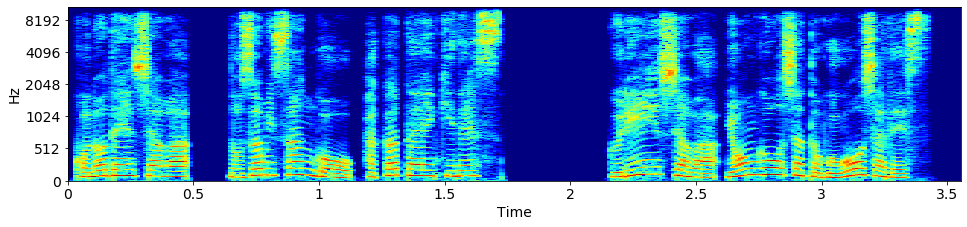

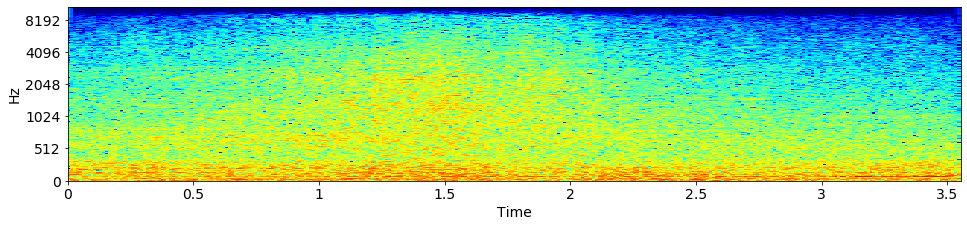

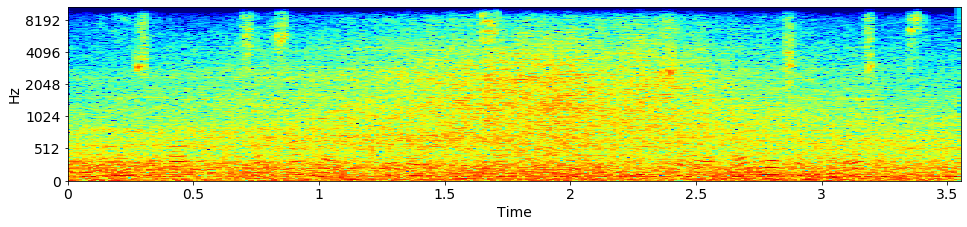

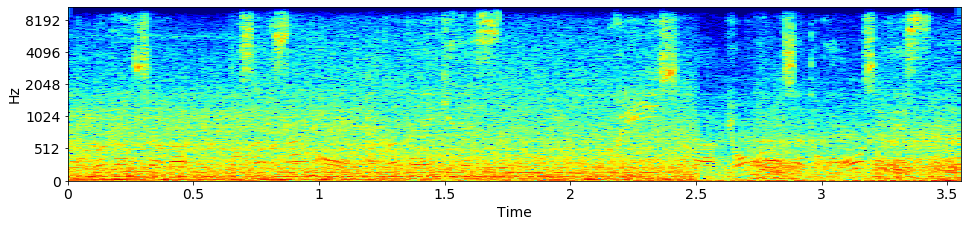

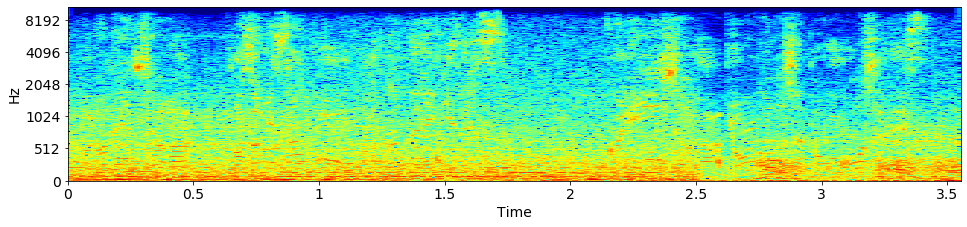

In [28]:
demo_dir = r'/home/common/db/audio_corpora/nele/jr_demo'
fig_dir = os.path.join(demo_dir, 'fig')

#snr = -8
filename = 'hikari_3.wav'
wav_clean_path = os.path.join(demo_dir, 'clean', filename)
wav_noise_path = os.path.join(demo_dir, 'noise', filename)
wav_ssdrc_path = os.path.join(demo_dir, 'ssdrc', filename)
wav_imgan_path = os.path.join(demo_dir, 'enhanced_modified', filename)

wav_clean_noised_path = os.path.join(demo_dir, 'mixed', 'hikari_3_clean_snr-8.wav')
wav_ssdrc_noised_path = os.path.join(demo_dir, 'mixed', 'hikari_3_ssdrc_snr-8.wav')
wav_imgan_noised_path = os.path.join(demo_dir, 'mixed', 'hikari_3_imgan_snr-8.wav')

# clean
for wav_path in [wav_clean_path, wav_noise_path, 
                 wav_clean_noised_path, wav_ssdrc_noised_path, wav_imgan_noised_path]:
    y, _ = librosa.load(wav_path)
    if wav_path==wav_clean_path:
        fig_path = os.path.join(fig_dir, os.path.basename(wav_path).replace('.wav', '') + '_clean.png')
    elif wav_path==wav_noise_path:
        fig_path = os.path.join(fig_dir, os.path.basename(wav_path).replace('.wav', '') + '_noise.png')
    elif wav_path==wav_ssdrc_path:
        fig_path = os.path.join(fig_dir, os.path.basename(wav_path).replace('.wav', '') + '_ssdrc.png')
    elif wav_path==wav_imgan_path:
        fig_path = os.path.join(fig_dir, os.path.basename(wav_path).replace('.wav', '') + '_imgan.png')
    else:
        fig_path = os.path.join(fig_dir, os.path.basename(wav_path).replace('.wav', '.png'))
    save_spectrogram(y, fig_path)

In [12]:
fig_path

'/home/common/db/audio_corpora/nele/jr_demo/fig/hikari_3_clean.png'